In [1]:
import awkward as ak
import numpy as np
import time
import coffea
import uproot
import hist
import vector
import os
import pandas as pd
import time
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from coffea.analysis_tools import PackedSelection
from collections import defaultdict
import pickle
import tokenize as tok
import re

from coffea.jetmet_tools import JetResolutionScaleFactor
from coffea.jetmet_tools import FactorizedJetCorrector, JetCorrectionUncertainty
from coffea.jetmet_tools import JECStack, CorrectedJetsFactory

from python.weight_class import Weights
from python.cms_utils import *
from python.smp_utils import *


In [2]:
class QJetMassProcessor(processor.ProcessorABC):
    '''
    Processor to run a Z+jets jet mass cross section analysis. 
    With "do_gen == True", will perform GEN selection and create response matrices. 
    Will always plot RECO level quantities. 
    '''
    def __init__(self, do_gen=True, ptcut=200., etacut = 2.5, ptcut_ee = 40., ptcut_mm = 29., skimfilename=None, jet_syst = "nominal"):
        
        self.lumimasks = getLumiMaskRun2()
        
        # should have separate lower ptcut for gen
        self.do_gen=do_gen
        self.ptcut = ptcut
        self.etacut = etacut        
        self.lepptcuts = [ptcut_ee, ptcut_mm]
        self.jet_syst = jet_syst
    
                
        binning = util_binning()
        
        ptreco_axis = binning.ptreco_axis
        mreco_axis = binning.mreco_axis
        ptgen_axis = binning.ptgen_axis     
        mgen_axis = binning.mgen_axis
    
        dataset_axis = binning.dataset_axis
        lep_axis = binning.lep_axis
        n_axis = binning.n_axis
        mass_axis = binning.mass_axis
        zmass_axis = binning.zmass_axis
        pt_axis = binning.pt_axis
        frac_axis = binning.frac_axis
        dr_axis = binning.dr_axis
        dr_fine_axis = binning.dr_fine_axis
        dphi_axis = binning.dphi_axis    
        syst_axis = binning.syst_axis
    
        weight_axis = hist.axis.Regular(100, 0, 5, name="corrWeight", label=r"Weight")
        #### weight to check what is causing this
        
    
        
        ### Plots to be unfolded
        h_ptjet_mjet_u_reco = hist.Hist(dataset_axis, ptreco_axis, mreco_axis,  storage="weight", label="Counts")
        h_ptjet_mjet_g_reco = hist.Hist(dataset_axis, ptreco_axis, mreco_axis,  storage="weight", label="Counts")

        
        
    
        
        cutflow = {}
        
        self.hists = {

            "ptjet_mjet_u_reco":h_ptjet_mjet_u_reco, 

            "ptjet_mjet_g_reco":h_ptjet_mjet_g_reco, 
            "cutflow": cutflow
        }
        self.means_stddevs = defaultdict()
    
        
    
    @property
    def accumulator(self):
        #return self._histos
        return self.hists
    def process(self, events0):
    
        #print(events.metadata.keys())
        dataset = events0.metadata['dataset']
        print(dataset)
        #lenprint(events.metadata['version'])
        filename = events0.metadata['filename']
        print('filename ', filename)
        jet_syst = self.jet_syst
        
        if dataset not in self.hists["cutflow"]:
            self.hists["cutflow"][dataset] = defaultdict(int)
            
        #####################################
        #### Find the IOV from the dataset name
        #####################################
        IOV = ('2016APV' if ( any(re.findall(r'APV',  dataset)) or any(re.findall(r'UL2016APV', dataset)))
               else '2018'    if ( any(re.findall(r'UL18', dataset)) or any(re.findall(r'UL2018',    dataset)))
               else '2017'    if ( any(re.findall(r'UL17', dataset)) or any(re.findall(r'UL2017',    dataset)))
               else '2016')
    
        sel = PackedSelection()
        print(IOV)
        events0 = events0[events0.PV.npvsGood > 0]

        events = events0
        
        if not self.do_gen:
            if "UL2016" in dataset: 
                trigsel = events0.HLT.IsoMu24 | events0.HLT.Ele27_WPTight_Gsf | events0.HLT.Photon175
            elif "UL2017" in dataset:
                trigsel = events0.HLT.IsoMu27 | events0.HLT.Ele35_WPTight_Gsf | events0.HLT.Photon200
            elif "UL2018" in dataset:
                trigsel = events0.HLT.IsoMu24 | events0.HLT.Ele32_WPTight_Gsf | events0.HLT.Photon200
            else:
                raise Exception("Dataset is incorrect, should have 2016, 2017, 2018: ", dataset)
            sel.add("trigsel", trigsel)    
            events = events[trigsel]


            
        
        if self.do_gen:
            if dataset not in self.means_stddevs : 
                average = np.average( events["LHEWeight"].originalXWGTUP )
                stddev = np.std( events["LHEWeight"].originalXWGTUP )
                self.means_stddevs[dataset] = (average, stddev)            
            average,stddev = self.means_stddevs[dataset]
            vals = (events["LHEWeight"].originalXWGTUP - average ) / stddev
            self.hists["cutflow"][dataset]["all events"] += len(events)
            events = events[ np.abs(vals) < 2 ]
            self.hists["cutflow"][dataset]["weights cut"] += len(events)
            
            
        if self.do_gen:
            #####################################
            ### Events with at least one gen jet
            #####################################

            

            sel.add("oneGenJet", 
                  ak.sum( (events.GenJetAK8.pt > 136.) & (np.abs(events.GenJetAK8.eta) < 2.5), axis=1 ) >= 1
            )
            events = events[sel.all('oneGenJet')]

            
            

        
        oneRecoJet = ak.sum( (events.FatJet.pt > 170.) & (np.abs(events.FatJet.eta) < 2.5), axis=1 ) >= 1
        events = events[oneRecoJet]
        if self.do_gen:
            w = events["LHEWeight"].originalXWGTUP
        else:
            w = np.full( len( events ), 1.0 )
        reco_jet = events.FatJet[:,0]
        self.hists["ptjet_mjet_u_reco"].fill(dataset=dataset, ptreco = reco_jet.pt, mreco = reco_jet.mass,  weight = w)
        self.hists["ptjet_mjet_g_reco"].fill(dataset=dataset, ptreco = reco_jet.pt, mreco = reco_jet.msoftdrop,  weight = w)

        return self.hists

    
    def postprocess(self, accumulator):
        return accumulator

        


In [3]:
def response_maker_nanov9(testing=False, do_gen=True, client=None, prependstr = "root://xcache/", skimfilename=None, eras_mc = None, jet_syst = "nominal", dask = False): 

    filedir = "samples/"

    eras_data = [
        'UL17NanoAOD'
           ]
    eras_mc = ['UL17NanoAOD']
    
    
    if not testing: 
        nworkers = 1
        chunksize = 200000
        maxchunks = None
    elif dask and (client != None):
        chunksize = 10000
        maxchunks = None
    else:
        client = None
        nworkers = 1
        if do_gen: 
            chunksize = 1000
        else:
            chunksize=100000
        maxchunks = 1
    fileset = {}
    if not testing: 
        
        if do_gen:

            dy_mc_filestr = "DYJetsToLL_M-50_HT_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8_%s_files.txt"

            for era in eras_mc: 
                filename = filedir + dy_mc_filestr % (era)
                with open(filename) as f:
                    dy_mc_files_all = [prependstr + i.rstrip() for i in f.readlines() if i[0] != "#"  ]  
                    for process in process_list:
                
                            
                        dy_mc_files = [file for file in dy_mc_files_all if process in file]
                        fileset[era+'_'+process] = dy_mc_files
        else: 
            datasets_data = [
                'SingleElectron_UL2017',
                'SingleMuon_UL2017',
            ]

            for dataset in datasets_data: 
                filename = filedir + dataset + '_NanoAODv9_files.txt'
                with open(filename) as f:
                    data_files = [prependstr + i.rstrip() for i in f.readlines()  if i[0] != "#" ]
                    fileset[dataset] = data_files
    else: 
        if do_gen:
            filename = filedir+"subset2016mc.txt"
            #fileset["UL2018"] = [prependstr+'/store/mc/RunIISummer20UL18NanoAODv9/DYJetsToLL_M-50_HT-200to400_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/270000/42C39ABF-7352-5547-A226-E3FA9DD0E72B.root']
            # with open(filename) as f:
            #     fileset["UL2016"] = [prependstr + i.rstrip() for i in f.readlines() if i[0] != "#" ]
            fileset = {'UL16NanoAODv9_DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8': ['root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL16NanoAODv9/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v2/260000/18D0A087-30BD-FE4E-B447-5F493C2D2794.root'],
 'UL16NanoAODv9_DYJetsToLL_M-50_HT-1200to2500_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8': ['root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL16NanoAODv9/DYJetsToLL_M-50_HT-1200to2500_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v2/2510000/09FD0207-04DE-5645-90D3-505984FB0E4A.root'],
 'UL16NanoAODv9_DYJetsToLL_M-50_HT-200to400_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8': ['root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL16NanoAODv9/DYJetsToLL_M-50_HT-200to400_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v2/250000/9F9E7CF3-DA95-0A4E-A088-4756E7C88560.root'],
 'UL16NanoAODv9_DYJetsToLL_M-50_HT-2500toInf_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8': [],
 'UL16NanoAODv9_DYJetsToLL_M-50_HT-400to600_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8': ['root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL16NanoAODv9/DYJetsToLL_M-50_HT-400to600_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v2/2520000/39F7B106-20C0-D949-96DB-31BFE3E34221.root'],
 'UL16NanoAODv9_DYJetsToLL_M-50_HT-70to100_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8': ['root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL16NanoAODv9/DYJetsToLL_M-50_HT-70to100_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v2/2430000/7D1595F7-417F-C94F-89F1-06560929ACBE.root'],
 'UL16NanoAODv9_DYJetsToLL_M-50_HT-800to1200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8': ['root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL16NanoAODv9/DYJetsToLL_M-50_HT-800to1200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v2/250000/67D80518-944A-D14C-ABAC-B33B3A852C4F.root']}
        else: 
            fileset["UL2017"] = [prependstr + "/store/data/Run2018A/SingleMuon/NANOAOD/UL2018_MiniAODv2_NanoAODv9_GT36-v1/2820000/FF8A3CD2-3F51-7A43-B56C-7F7B7B3158E3.root"]

                

    if client == None:         

        run = processor.Runner(
            executor = processor.FuturesExecutor(compression=None, workers=nworkers),
            schema=NanoAODSchema,
            chunksize=chunksize,
            maxchunks=maxchunks,
            skipbadfiles=True
        )
    else: 
        run = processor.Runner(
            executor = processor.DaskExecutor(client=client, retries=12, status=True),
            schema=NanoAODSchema,
            chunksize=chunksize,
            maxchunks=maxchunks,
            skipbadfiles=True
        )

    
    print("Running...")
    # print(fileset)
    # if client == None or testing == True:
    #     dataset_runnable, dataset_updated = preprocess(
    #         fileset,
    #         align_clusters=False,
    #         step_size=100_000,
    #         files_per_batch=1,
    #         skip_bad_files=True,
    #         save_form=False,
    #     )
    #     to_compute = apply_to_fileset(
    #             QJetMassProcessor(do_gen=do_gen, skimfilename=skimfilename),
    #             max_chunks(dataset_runnable, 1000),
    #             schemaclass=NanoAODSchema,
    #         )
    #     (output, ) = dask.compute(to_compute) 
        
    output = run(
        fileset,
        "Events",
        processor_instance=QJetMassProcessor(do_gen=do_gen, skimfilename=skimfilename, jet_syst = jet_syst),
    )

    print("Done running")
    
    if do_gen:
        if testing == False:
            fname_out = 'xs_test_gen.pkl'
        else:
            fname_out = 'test_xs_test_gen.pkl'
    else:
        if testing == True:
            fname_out = 'test_xs_test_reco.pkl'
        else:
            fname_out = 'xs_test_reco.pkl'
    with open(fname_out, "wb") as f:
        pickle.dump( output, f )

In [4]:
from distributed import Client
from lpcjobqueue import LPCCondorCluster

cluster = LPCCondorCluster(transfer_input_files = [ "correctionFiles", "samples", "python"], 
                           ship_env = False,
                           memory = "5GB",
                          scheduler_options={"dashboard_address": ":2024"})
cluster.adapt(minimum=0, maximum=10000)


client = Client(cluster)
client

Connection method: Cluster object,Cluster type: lpcjobqueue.LPCCondorCluster
Dashboard: http://131.225.191.74:2024/status,
Dashboard: http://131.225.191.74:2024/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://131.225.191.74:10082,Workers: 0
Dashboard: http://131.225.191.74:2024/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
response_maker_nanov9(testing=False, do_gen=False, client=client, prependstr="root://cmsxrootd.fnal.gov/", eras_mc=None, jet_syst = 'nominal', dask = True)

Running...
[#                                       ] | 3% Completed |  4min  2.0s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 3023411.0: TOOL at 131.225.191.74 failed to send file(s) to <131.225.189.251:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_0lbnhf/correctionFiles/JEC/Summer19UL16APV_RunBCD_V7_DATA/Summer19UL16APV_RunBCD_V7_DATA_UncertaintySources_AK8PFchs.junc.txt; SCHEDD at 131.225.189.251 - |Error: receiving file /storage/local/data1/condor/spool/3411/0/cluster3023411.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL16APV_RunBCD_V7_DATA/Summer19UL16APV_RunBCD_V7_DATA_UncertaintySources_AK8PFPuppi.junc.txt


[#                                       ] | 3% Completed |  4min  3.4s

Task exception was never retrieved
future: <Task finished name='Task-46849' coro=<_wrap_awaitable() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py:118> exception=AssertionError()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 119, in _wrap_awaitable
    return await aw
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 69, in _
    assert self.status == Status.running
AssertionError


[##                                      ] | 5% Completed |  4min 13.7s

DCSchedd::spoolJobFiles:7002:File transfer failed for target job 3023424.0: TOOL at 131.225.191.74 failed to send file(s) to <131.225.189.251:9618>: error sending /uscmst1b_scratch/lpc1/3DayLifetime/amandal2/tmpq_0lbnhf/correctionFiles/JEC/Summer19UL16APV_RunEF_V7_DATA/Summer19UL16APV_RunEF_V7_DATA_UncertaintySources_AK4PFPuppi.junc.txt; SCHEDD at 131.225.189.251 - |Error: receiving file /storage/local/data1/condor/spool/3424/0/cluster3023424.proc0.subproc0.tmp/correctionFiles/JEC/Summer19UL16APV_RunBCD_V7_DATA/Summer19UL16APV_RunBCD_V7_DATA_UncertaintySources_AK8PFPuppi.junc.txt


[##                                      ] | 6% Completed |  4min 15.0s

Task exception was never retrieved
future: <Task finished name='Task-49445' coro=<_wrap_awaitable() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py:118> exception=AssertionError()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 119, in _wrap_awaitable
    return await aw
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 69, in _
    assert self.status == Status.running
AssertionError


[                                        ] | 0% Completed | 16.4sin 27.7s

Failed to commit and disconnect from queue.


[#######                                 ] | 19% Completed |  6min 31.6s

Failed to commit and disconnect from queue.


Done running#############################] | 100% Completed | 11min  3.7s


In [6]:
import pickle
import matplotlib.pyplot as plt
with open("test_xs_test_gen.pkl", "rb") as f:
    output = pickle.load( f )
with open("test_xs_test_reco.pkl", "rb") as f:
    output_data = pickle.load( f )

(0.0, 300.0)

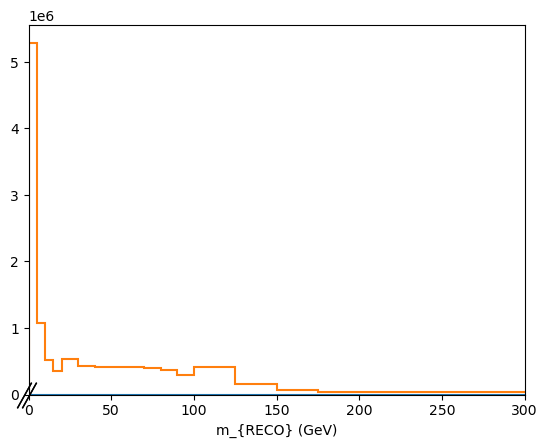

Failed to commit and disconnect from queue.
Task exception was never retrieved
future: <Task finished name='Task-151554' coro=<_wrap_awaitable() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py:118> exception=AssertionError()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 119, in _wrap_awaitable
    return await aw
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 69, in _
    assert self.status == Status.running
AssertionError
Task exception was never retrieved
future: <Task finished name='Task-152903' coro=<_wrap_awaitable() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py:118> exception=AssertionError()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/deploy/spec.py", line 119, in _wrap_awaitable
    return await aw
  File "/opt/conda/lib/python3.10/site-packages/dis

In [7]:
output['ptjet_mjet_g_reco'].project("mreco").plot()
output_data['ptjet_mjet_g_reco'].project("mreco").plot()
plt.xlim(0,300)